# Part 2: Using LAMMPS to simulate a solid/electrolyte interface

Interfacial systems are extremely ubiquitous - from membranes in biological systems to electrode-electrolyte interfaces in batteries. In this part of the practical we will explore an interfacial system of relevance for numerous technological applications: a solution of NaCl in water in contact with graphene. Our goal is to learn how we can use a simulation trajectory to learn useful information about the structural and dynamic properties of this system.

You have now got experience in running simulations with LAMMPS, and you should have generated a trajectory to analyse. Since it can take quite a while to converge certain properties (longer than you can do in the time of this practical on a few cores) we have also provided you with a long `converged' trajectory that you can run your analysis on.

In this section you can run the analysis as you would like -- you can for example explore the broad set of tools available from the _MDAnalysis_ python package, or you are free to write your own analysis scripts, use a different code or some combination of all of the above!

If you would like to use MDAnalysis we have given you a head start in the cell below, loading the `Universe' with which you can use to do your analysis.

In [80]:
#Load libraries you might use
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import ase
import ase.io 
from ase import Atoms
from ase.visualize import view

import MDAnalysis as mda
from MDAnalysis.analysis.lineardensity import LinearDensity
import MDAnalysis.analysis.msd as msdmda
from MDAnalysis.analysis.distances import distance_array
from MDAnalysis.lib import distances
from MDAnalysis.analysis.base import AnalysisBase

# Some useful constants
m_na = 22.98976928
m_cl = 35.453
m_o = 15.999
cm_to_angstrom = 1e8
ps_to_s = 1e-12
NA = 6.02214076e23 # Avogadro's constant

### TODO: change this path to the location on CSD3
data_path = '/Users/karafong/files/Cambridge/LJC summer school/practical/simulations_graphene_electrolyte/graphene-nacl-test/nvt/'
traj = 'traj_unwrapped_0.dcd'
top = 'init_nvt.xyz'

#create universe
u = mda.Universe(f'{data_path}/{top}', f'{data_path}/{traj}', format = 'LAMMPS')
atoms = u.select_atoms('all')   
set(atoms.types)
na = u.select_atoms('name Na')
cl = u.select_atoms('name Cl')
c = u.select_atoms('name C')
ox = u.select_atoms('name O')  

## How does the interface affect the electrolyte struture?

### Density profiles

The first question we want to explore is: what is the structure of the electrolyte at the interface? To address this, let's analyse the density profile of the electrolyte as a function of distance (in the z direction) from the interface. 

**Make a plot of the local density of the sodium ion, chloride, and water's oxygen atoms as a function of distance from the graphene.** Consider both a plot of mass density ($g/cm^3$) as well as number density ($\AA^{-3}$).

In [33]:
u.add_TopologyAttr('charges')

binsize=0.24

# Sodium
D = LinearDensity(na, delta=1.0, binsize=binsize)
D.run(step=1)

hist = D.results['z']['pos']
bincenters = np.arange(len(hist))*binsize
density_na = np.array([bincenters, hist]).transpose()

# Chlorine
D = LinearDensity(cl, delta=1.0, binsize=binsize)
D.run(step=1)

hist = D.results['z']['pos']
bincenters = np.arange(len(hist))*binsize
density_cl = np.array([bincenters, hist]).transpose()

# Water
D = LinearDensity(ox, delta=1.0, binsize=binsize)
D.run(step=1)

hist = D.results['z']['pos']
bincenters = np.arange(len(hist))*binsize
density_ox = np.array([bincenters, hist]).transpose()


/Users/karafong/miniconda3/envs/rosetta/lib/python3.8/site-packages/MDAnalysis/analysis/lineardensity.py:53: DeprecationWarning: `pos` is deprecated and will be removed in version 3.0.0. Please use `mass_density` instead.
  warnings.warn(


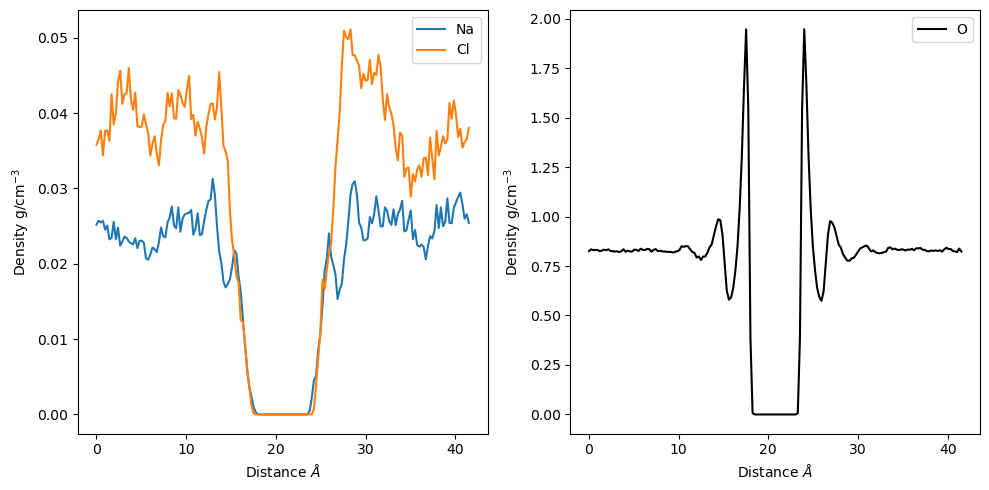

In [48]:
# plotted as mass density

fig, axes = plt.subplots(1,2, figsize=(10,5))
ax1, ax2 = axes
ax1.plot(density_na[:,0], density_na[:,1], label = 'Na')    
ax1.plot(density_cl[:,0], density_cl[:,1], label = 'Cl')
ax2.plot(density_ox[:,0], density_ox[:,1], label = 'O', color='k')

for ax in axes:
    ax.legend()
    ax.set_xlabel(r'Distance $\AA$')
    ax.set_ylabel(r'Density g/cm$^{-3}$')

plt.tight_layout()

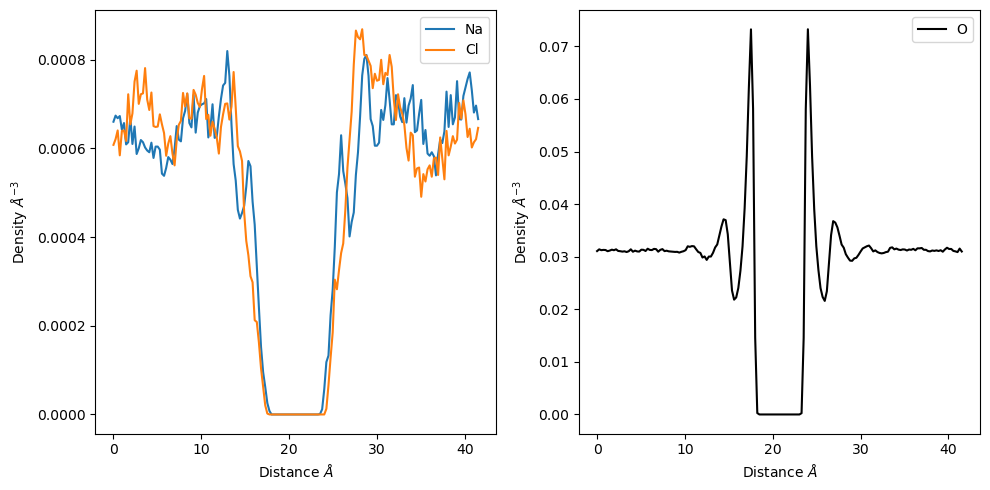

In [52]:
# plotted as number density
convert = 1/(cm_to_angstrom**3)*NA
fig, axes = plt.subplots(1,2, figsize=(10,5))
ax1, ax2 = axes
ax1.plot(density_na[:,0], density_na[:,1]*convert/m_na, label = 'Na')    
ax1.plot(density_cl[:,0], density_cl[:,1]*convert/m_cl, label = 'Cl')
ax2.plot(density_ox[:,0], density_ox[:,1]*convert/m_o, label = 'O', color='k')

for ax in axes:
    ax.legend()
    ax.set_xlabel(r'Distance $\AA$')
    ax.set_ylabel(r'Density $\AA^{-3}$')

plt.tight_layout()

**Qs:** Does one ion type (Na or Cl) have a greater propensity to the graphene? Is this in line with what you would expect physically?

**A:** To compare adsorption propensity, we can look at the plot of number density (rather than mass density). Here, we see that...

The chloride ion has a greater propensity for the graphene interface than the sodium ion. This may seem surprising, given that both ions interact with the carbon with the same Lennard-Jones parameter $\epsilon$. We can rationalize this behaviour by recalling that the chloride ion is larger, and will thus have a weaker free energy of hydration. Therefore, it may be more favorable for the chloride ion to partially desolvate to adsorb on the graphene.

**Qs:** After what distance from does the graphene the water recovers its bulk density?

**A:** We observe approximately two interfacial layers, then see that 10 Angstroms from the surface.

### Water orientation

Following from the analysis of the overall structure of the electrolyte, it would also be interesting to understand how the interface effects the orientation of the waters. To look at this you should define a function that computes the dipole orientation of the water ($\theta$) relative to the z direction. Then, **make a plot of $cos(\theta)$ as a function of distance from the interface.**

In [160]:
# get the positions of each water molecule
def get_water_pos(u):
    oh_dist = distance_array(u.atoms.select_atoms('name O').positions,
                                 u.atoms.select_atoms('name H').positions,
                                 box=u.dimensions)

    idx = np.argpartition(oh_dist, 3, axis=-1)
    opos = u.atoms.select_atoms('name O').positions
    h1pos = u.atoms.select_atoms('name H')[idx[:,0]].positions
    h2pos = u.atoms.select_atoms('name H')[idx[:,1]].positions

    return [opos, h1pos, h2pos]

# compute the dipole orientation of each water molecule
def get_orientation(u, water_pos):
    box_center = u.dimensions[:3]/2
    # shift oxygen position to center of box to avoid periodic boundary issues
    o_pos = water_pos[0] - box_center
    h1pos = water_pos[1] - o_pos
    h2pos = water_pos[2] - o_pos
    print(h1pos[0,:], h2pos[0,:])

    dipole_vec = (h2pos + h1pos) * 0.5
    print(dipole_vec[0,:])
    unit_dipole_vec = dipole_vec / np.linalg.norm(dipole_vec, axis=-1)[:,np.newaxis]
    print(unit_dipole_vec[0,:])

    z = np.array([0,0,1])
    cos_theta = np.dot(unit_dipole_vec, z)
    return cos_theta

frame 0
[ 9.587885 11.138845 20.078848] [10.333065 11.364889 21.5142  ]
[ 9.960475 11.251867 20.796524]
[0.388208   0.43853983 0.8105414 ]


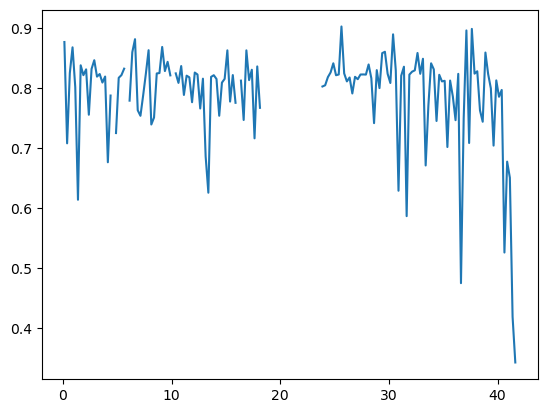

In [161]:
n_water = len(ox)
bins = np.arange(0, u.dimensions[2], 0.25)
o_z_all = []
cos_theta_all = []
print(f'frame {ts.frame}')
water_pos = get_water_pos(u)
o_z = water_pos[0][:,2] % u.dimensions[2]
cos_theta = get_orientation(u, water_pos)
means, edges, binnumber = stats.binned_statistic(o_z, cos_theta, statistic='mean', bins=bins)
o_z_all.append(o_z)
cos_theta_all.append(means)
edges = 0.5 * (edges[1:] + edges[:-1])
# hist = np.array([edges,means])
# hist = hist.transpose()
plt.plot(edges, means)

frame 0
frame 100
frame 200
frame 300
frame 400
frame 500
frame 600
frame 700
frame 800
frame 900
frame 1000
frame 1100
frame 1200
frame 1300
frame 1400
frame 1500
frame 1600
frame 1700
frame 1800
frame 1900
frame 2000
frame 2100
frame 2200
frame 2300
frame 2400
frame 2500
frame 2600
frame 2700
frame 2800
frame 2900
frame 3000
frame 3100
frame 3200
frame 3300
frame 3400
frame 3500
frame 3600
frame 3700
frame 3800
frame 3900
frame 4000
frame 4100
frame 4200
frame 4300
frame 4400
frame 4500
frame 4600
frame 4700
frame 4800
frame 4900
frame 5000
frame 5100
frame 5200
frame 5300
frame 5400
frame 5500
frame 5600
frame 5700
frame 5800
frame 5900
frame 6000
frame 6100
frame 6200
frame 6300
frame 6400
frame 6500
frame 6600
frame 6700
frame 6800
frame 6900
frame 7000
frame 7100
frame 7200
frame 7300
frame 7400
frame 7500
frame 7600
frame 7700
frame 7800
frame 7900
frame 8000
frame 8100
frame 8200
frame 8300
frame 8400
frame 8500
frame 8600
frame 8700
frame 8800
frame 8900
frame 9000
frame 9100


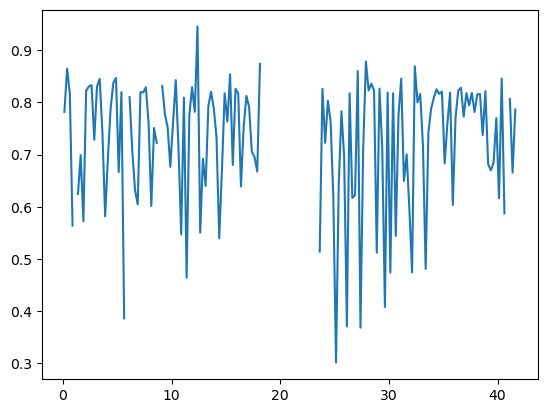

In [154]:
n_water = len(ox)
bins = np.arange(0, u.dimensions[2], 0.25)
o_z_all = []
cos_theta_all = []
for ts in u.trajectory[::100]:
    print(f'frame {ts.frame}')
    water_pos = get_water_pos(u)
    o_z = water_pos[0][:,2] % u.dimensions[2]
    cos_theta = get_orientation(u, water_pos)
    means, edges, binnumber = stats.binned_statistic(o_z, cos_theta, statistic='mean', bins=bins)
    o_z_all.append(o_z)
    cos_theta_all.append(means)
edges = 0.5 * (edges[1:] + edges[:-1])
# hist = np.array([edges,means])
# hist = hist.transpose()
plt.plot(edges, means)

In [29]:
class orientation(AnalysisBase):
    def __init__(self, atomgroup, axis='z', bins=50, **kwargs):
        super(orientation, self).__init__(atomgroup.universe.trajectory,
                                          **kwargs)
        self._axis = axis
        self._bins = bins
        self._ag = atomgroup

    def _getCosTheta(self, ag, axis):

        oh_dist = distance_array(ag.select_atoms('name O').positions,
                                 ag.select_atoms('name H').positions,
                                 box=ag.dimensions)

        idx = np.argpartition(oh_dist, 3, axis=-1)
        opos = ag.select_atoms('name O').positions
        h1pos = ag.select_atoms('name H')[idx[:,0]].positions
        h2pos = ag.select_atoms('name H')[idx[:,1]].positions

        center = ag.dimensions[:3]/2
        h1pos = distances.apply_PBC(h1pos-opos+center, ag.dimensions)
        h2pos = distances.apply_PBC(h2pos-opos+center, ag.dimensions)

        dipVector0 = (h2pos + h1pos) * 0.5 - center
        unitdipVector0 = dipVector0 / \
        np.linalg.norm(dipVector0, axis=1)[:, None]

        opos = distances.apply_PBC(opos, ag.dimensions)
        if axis == "z":
            valdip = np.array([opos[:,2],unitdipVector0[:,2]])
        elif axis == "x":
            valdip = np.array([opos[:,0],unitdipVector0[:,0]])
        elif axis == "y":
            valdip = np.array([opos[:,1],unitdipVector0[:,1]])

        return (valdip.transpose())

    def _getHistogram(self, CosThetra, bins):

        means, edges, binnumber = stats.binned_statistic(CosThetra[:,:,0].flatten(),
                                                 CosThetra[:,:,1].flatten(),
                                                 statistic='mean', bins=bins)

        edges = 0.5 * (edges[1:] + edges[:-1])
        hist = np.array([edges,means])
        hist = hist.transpose()
        return (hist)


    def _prepare(self):
        # OPTIONAL
        # Called before iteration on the trajectory has begun.
        # Data structures can be set up at this time
        self.CosTheta = []

    def _single_frame(self):
        # REQUIRED
        # Called after the trajectory is moved onto each new frame.
        # store result of `some_function` for a single frame
        self.CosTheta.append(self._getCosTheta(self._ag, self._axis))

    def _conclude(self):
        # OPTIONAL
        # Called once iteration on the trajectory is finished.
        # Apply normalisation and averaging to results here.
        self.CosTheta = np.array(self.CosTheta)
        self.result = self._getHistogram(self.CosTheta, self._bins)



ow = "name O H"
bins = 100
ori_analysis = orientation(u,bins=bins)
ori_analysis.run(step=4)



Text(0, 0.5, 'Probability Density')

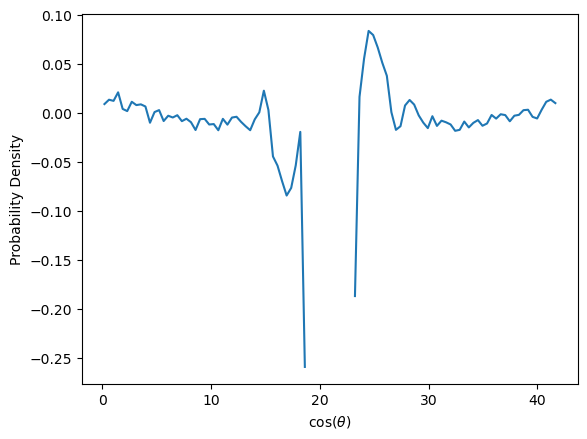

In [31]:
fig, ax = plt.subplots()
ax.plot(ori_analysis.result[:,0], ori_analysis.result[:,1])
ax.set_xlabel(r'$\cos(\theta)$')
ax.set_ylabel('Probability Density')

**Qs:** Do the waters have a preferential orientation closer to the graphene compared to in bulk? 

### Diffusion coefficients

Beyond structrual properties, we also want to understand the dynamics of the system and how tranpsort differs for the two ions and the water. **Compute the self-diffusion coefficient of the Na, Cl, and water.** We recommend using the Einstein relation to obtain the diffusion coefficient from the slope of a plot of MSD vs time (recall from the lectures that $D = \frac{1}{2d} \frac{d}{dt} \langle r^2(t)\rangle$). You can either write your own code to compute the mean-squared displacement or try out the msd module from MDAnalysis. Since the system is anisotropic in the z-direction, you should only compute the diffusion coefficients based on transport in the x- and y-directions.

When plotting the MSD vs time, it may be useful to note that the snapshots stored in the provided trajectory file are collected every 1 ps. 

In [101]:
# compute MSDs for each species
MSD = msdmda.EinsteinMSD(u, select='name Na', msd_type='xy', fft=True)
MSD.run()
msd_na = MSD.results.timeseries

MSD = msdmda.EinsteinMSD(u, select='name Cl', msd_type='xy', fft=True)
MSD.run()
msd_cl = MSD.results.timeseries

MSD = msdmda.EinsteinMSD(u, select='name O', msd_type='xy', fft=True)
MSD.run()
msd_o = MSD.results.timeseries

In [106]:
traj = u.trajectory
traj.dt

1.0

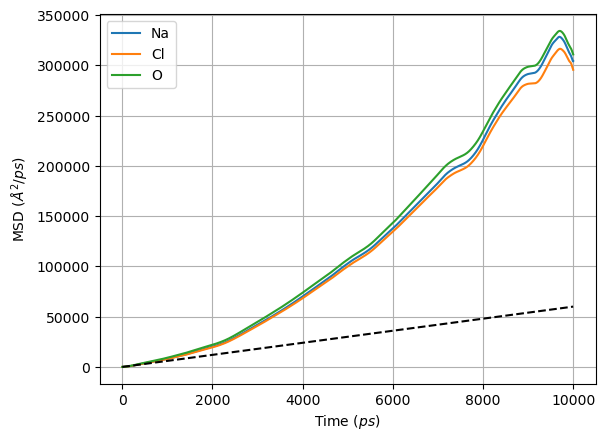

In [ ]:
# Plot MSDs

msds = [msd_na, msd_cl, msd_o]
labels = ['Na', 'Cl', 'O']

nframes = len(u.trajectory)
timestep = 1 # time between frames (ps)
times = np.arange(nframes)*timestep 

fig = plt.figure()
ax = plt.axes()
for msd, label in zip(msds, labels):
    ax.plot(times, msd, label=label)
# plot a straight line to guide the eye
ax.plot(times, times*6, c="black", ls="--")
ax.legend()
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid()

ax.set_xlabel(r'Time ($ps$)')
ax.set_ylabel(r'MSD ($\AA^2/ps$)')
plt.legend()

plt.show()


In [110]:
def msd_fft_1d(r):
    """Calculates mean square displacement of the array r using the fast Fourier transform."""

    def autocorrFFT(x):
        """Calculates the position autocorrelation function using the fast Fourier transform."""
        N = len(x)
        F = np.fft.fft(x, n=2 * N)  # 2*N because of zero-padding
        PSD = F * F.conjugate()
        res = np.fft.ifft(PSD)
        res = (res[:N]).real  # now we have the autocorrelation in convention B
        n = N * np.ones(N) - np.arange(0, N)  # divide res(m) by (N-m)
        return res / n  # this is the autocorrelation in convention A

    N = len(r)
    D = np.square(r)
    D = np.append(D, 0)
    S2 = autocorrFFT(r)
    Q = 2 * D.sum()
    S1 = np.zeros(N)
    for m in range(N):
        Q = Q - D[m - 1] - D[N - m]
        S1[m] = Q / (N - m)
    return S1 - 2 * S2


def calc_NE_xyz(atom_positions, times):
    """Calculates Nernst Einstein conductivity for either cations or anions.
    Returns separate values for x, y, and z directions
    """
    # Current code assumes anion and cation selections are single atoms
    # Also assumes monovalent ions
    cond_NE = np.zeros([len(times), 3])
    n_atoms = np.shape(atom_positions)[1]
    for atom_num in range(n_atoms):
        r = atom_positions[:, atom_num, :]
        for i in range(3):  # average over x, y, z
            msd_temp = msd_fft_1d(np.array(r[:, i]))
            cond_NE[:, i] += msd_temp
    return cond_NE

def get_water_diffusion(u):
    def compute_water_msd(u, waters, times, run_start):
        time = 0
        o_positions = np.zeros((len(times), len(waters), 3))
        for ts in u.trajectory[run_start:]:
            not_carbon = u.select_atoms("not name C")
            # o_positions[time, :, :] = waters.positions - not_carbon.center_of_mass(
            #     wrap=False
            # )
            o_positions[time, :, :] = waters.positions 
            time += 1
        msd_water = np.array(calc_NE_xyz(o_positions, times)) / 2.0 / len(waters)
        return msd_water

    msd_water = compute_water_msd(
        u, ox, times, run_start=0
    )

    # average x and y components
    msd_water = (msd_water[:, 0] + msd_water[:, 1]) / 2
    
    return msd_water

In [111]:
msd_water_no_com = get_water_diffusion(u)

In [98]:
msd_water = get_water_diffusion(u)

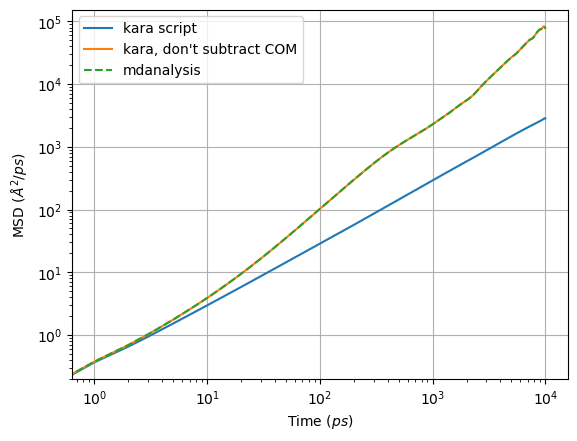

In [117]:
# Plot MSDs

msds = [msd_na, msd_cl, msd_o]
labels = ['Na', 'Cl', 'O']

nframes = len(u.trajectory)
timestep = 1 # time between frames (ps)
times = np.arange(nframes)*timestep 

fig = plt.figure()
ax = plt.axes()
ax.plot(times, msd_water, label='kara script')
ax.plot(times, msd_water_no_com, label='kara, don\'t subtract COM')
ax.plot(times, msd_o/4, '--',label='mdanalysis')
# plot a straight line to guide the eye
# ax.plot(times, times*6, c="black", ls="--")
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()

ax.set_xlabel(r'Time ($ps$)')
ax.set_ylabel(r'MSD ($\AA^2/ps$)')
plt.legend()

plt.show()


In [85]:
# Fit MSDs

# choose fitting regime (in ps)
start = 1
end = 10

# convert to cm^2/s
convert = 1/(cm_to_angstrom**2)/ps_to_s

for msd, label in zip(msds, labels):
    slope_avg, _, _, _, _ = stats.linregress(times[start:end], msd[start:end])
    diffusion_coefficient = slope_avg/4*convert # d=2 because we only averaged over the x-y directions
    print(f'Diffusion coefficient for {label}: {diffusion_coefficient} $cm^2/s$')


Diffusion coefficient for Na: 2.413783977717551e-05 $cm^2/s$
Diffusion coefficient for Cl: 2.6278751947290775e-05 $cm^2/s$
Diffusion coefficient for O: 3.817544093902956e-05 $cm^2/s$


**Qs:** How can you check how reliable your simulation results are? (Hint: Think about where you decide to fit your MSD curve)

**Qs:** Comparison to experimental data?

### Final reflections

**Qs** Do you think we are ready to publish our results? Can you think of some of the weaknesses in the simulations we have run above? For example you can think in terms of 

(a) the physical set-up. What are the constranints we impose on the system? Are these realistic? What would you instead do to improve the setup?

(b) the potential energy surface we use to represent the system. Is this the most accurate description of the system? Are there interactions that we are not accounting for with our current classical model?